In [23]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, Returns, AnnualizedVolatility, CustomFactor
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders.equity_pricing_loader import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data import bundles

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
#os.environ['ZIPLINE_ROOT'] = r'C:\Users\leo_s\.zipline'
os.environ['ZIPLINE_ROOT'] = '/home/leo/.zipline/'

In [4]:
start_session = pd.Timestamp('2016-6-26', tz = 'utc')
end_session = pd.Timestamp('2019-6-26', tz = 'utc')

register(
	'crypto_portfolio',
	csvdir_equities(
		['daily'], 
		'/home/leo/git_projects/portfolio_analytics/data/', 
		), 
	calendar_name = '24/7',
	start_session = start_session,
	end_session = end_session
	)

<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x7fa9e5059c18>>

In [5]:
bundle_data = bundles.load('crypto_portfolio')

In [6]:
universe = AverageDollarVolume(window_length = 7).rank(ascending = False) <= 8 
trading_calendar = get_calendar('24/7') 

In [53]:
class RegressionAgainstTime(CustomFactor):

    #TODO: choose a window length that spans one year's worth of trading days
    window_length = 30
    
    #TODO: use USEquityPricing's close price
    inputs = [USEquityPricing.close]
    
    #TODO: set outputs to a list of strings, which are names of the outputs
    #We're calculating regression coefficients for two independent variables, 
    # called beta and gamma
    outputs = ['beta', 'gamma']
    
    def compute(self, today, assets, out, dependent):
        
        #TODO: define an independent variable that represents time from the start to end
        # of the window length. E.g. [1,2,3...252]
        t1 = np.arange(self.window_length)
        
        #TODO: define a second independent variable that represents time ^2
        t2 = t1 ** 2
        
        # combine t1 and t2 into a 2D numpy array
        X = np.array([t1, t2]).T

    
        #TODO: the number of stocks is equal to the length of the "out" variable,
        # because the "out" variable has one element for each stock
        n_stocks = len(out)
        # loop over each asset

        for i in range(n_stocks):
            # TODO: "dependent" is a 2D numpy array that
            # has one stock series in each column,
            # and days are along the rows.
            # set y equal to all rows for column i of "dependent"
            y = dependent[:, i]
            
            # TODO: run a regression only if all values of y
            # are finite.
            if np.all(np.isfinite(y)) :
                # create a LinearRegression object
                regressor = LinearRegression()
                
                # TODO: fit the regressor on X and y
                regressor.fit(X, y)
                
                # store the beta coefficient
                out.beta[i] = regressor.coef_[0]
                
                #TODO: store the gamma coefficient
                out.gamma[i] = regressor.coef_[1]
            else:
                # store beta as not-a-number
                out.beta[i] = np.nan
                
                # TODO: store gammas not-a-number
                out.gamma[i] = np.nan

In [60]:
beta_factor = RegressionAgainstTime(mask=universe).beta.rank()
gamma_factor = RegressionAgainstTime(mask = universe).gamma.rank()

hist_return = Returns(window_length = 30).rank()
hist_volatility = AnnualizedVolatility(window_length = 30).rank(ascending = False)
hist_volume = AverageDollarVolume(window_length = 30).rank()
adv_momentum = (beta_factor * gamma_factor).rank()

comp_factor = (hist_return * hist_volatility * hist_volume * adv_momentum).rank()

In [61]:
p = Pipeline(screen = universe)
p.add(hist_return, 'hist_return')
p.add(hist_volatility, 'hist_volatility')
p.add(hist_volume, 'hist_volume')
p.add(adv_momentum, 'adv_momentum')
p.add(comp_factor, 'comp_factor')

In [62]:
# Very Useful Guidance on how to build the pipeline engine

from zipline.assets._assets import Equity
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader


EOD_BUNDLE_NAME = 'cryptocompare_cryptocurrencies'


class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader)

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader


def build_pipeline_engine(bundle_data, trading_calendar):
    pricing_loader = PricingLoader(bundle_data)

    engine = SimplePipelineEngine(
        get_loader = pricing_loader.get_loader,
        calendar = trading_calendar.all_sessions,
        asset_finder = bundle_data.asset_finder)

    return engine

In [63]:
engine = build_pipeline_engine(bundle_data, trading_calendar)

In [64]:
pipeline_data = engine.run_pipeline(p, start_session + pd.DateOffset(days = 31), end_session)

In [65]:
pipeline_data

adv_momentum  comp_factor  \
2016-07-27 00:00:00+00:00 Equity(0 [BTC])            1.0          4.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            3.0          3.0   
                          Equity(6 [ETH])            2.0          2.0   
                          Equity(7 [LSK])            5.0          6.0   
                          Equity(8 [LTC])            4.0          5.0   
                          Equity(9 [MAID])           6.0          7.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-28 00:00:00+00:00 Equity(0 [BTC])            1.0          4.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            3.0          2.0   
                          Equity(6 [ETH])            2.0          3.0   
                          Equity(7 [LSK])            5.0          6.0   
                          Equity(8 [LTC])            4.0          5.0   
                          Equity(9 [MAID])           6.0          7.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-29 00:00:00+00:00 Equity(0 [BTC])            2.0          7.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            4.0          2.0   
                          Equity(6 [ETH])            3.0          5.0   
                          Equity(7 [LSK])            5.0          4.0   
                          Equity(8 [LTC])            1.0          3.0   
                          Equity(9 [MAID])           6.0          6.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-30 00:00:00+00:00 Equity(0 [BTC])            2.0          5.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            5.0          3.0   
                          Equity(6 [ETH])            4.0          4.0   
                          Equity(7 [LSK])            1.0          2.0   
                          Equity(8 [LTC])            7.0          7.0   
...                                                  ...          ...   
2019-06-23 00:00:00+00:00 Equity(2 [DASH])           7.0          8.0   
                          Equity(3 [DCR])            6.0          6.0   
                          Equity(6 [ETH])            4.0          5.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          7.0   
                          Equity(11 [XEM])           1.0          1.0   
2019-06-24 00:00:00+00:00 Equity(0 [BTC])            2.0          5.0   
                          Equity(1 [BTS])            3.0          2.0   
                          Equity(2 [DASH])           7.0          8.0   
                          Equity(3 [DCR])            6.0          6.0   
                          Equity(6 [ETH])            4.0          4.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          7.0   
                          Equity(11 [XEM])           1.0          1.0   
2019-06-25 00:00:00+00:00 Equity(0 [BTC])            2.0          5.0   
                          Equity(1 [BTS])            3.0          2.0   
                          Equity(2 [DASH])           7.0          8.0   
                          Equity(3 [DCR])            6.0          6.0   
                          Equity(6 [ETH])            4.0          4.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          7.0   
                          Equity(11 [XEM])           1.0          1.0   
2019-06-26 00:00:00+00:00 Equity(0 [BTC])            2.0          4.0   
                          Equ

In [11]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar = trading_calendar,
    first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader = None,
    equity_daily_reader = bundle_data.equity_daily_bar_reader,
    adjustment_reader = bundle_data.adjustment_reader)

In [12]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [15]:
import alphalens as al

def make_factor_data(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    for factor in factor_names:
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [1]
        )
    
    return factor_data['age']

In [16]:
factor_data = make_factor_data(pipeline_data, data_portal, trading_calendar, start_session, end_session)

/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [18]:
# Make factor returns plot on page one

import time
import alphalens as al

def make_factor_plot(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    start_time = time.clock()
    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [1]
        )
    end_time = time.clock()
    print("Time to get arrange factor data: %.2f secs" % (end_time - start_time))
    
    ls_factor_returns = []

    start_time = time.clock()
    for i, factor in enumerate(factor_names):
        ls = al.performance.factor_returns(factor_data[factor])
        ls.columns = [factor]
        ls_factor_returns.append(ls)
    end_time = time.clock()
    print("Time to generate long/short returns: %.2f secs" % (end_time - start_time))

    df_ls_factor_returns = pd.concat(ls_factor_returns, axis = 1)
    (1 + df_ls_factor_returns).cumprod().plot(title = 'Factor Returns');
    return df_ls_factor_returns

/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Formatting factor data for: age
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 0.87 secs
Time to generate long/short returns: 0.65 secs


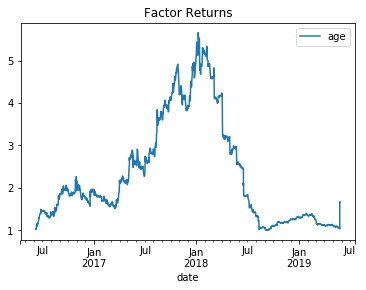

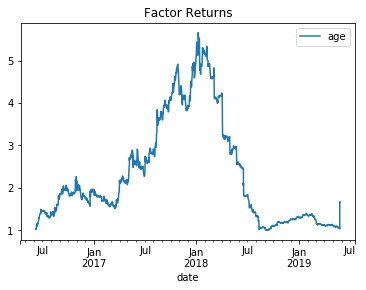

In [19]:
factor_plot = make_factor_plot(pipeline_data, data_portal, trading_calendar, start_session, end_session)
(1 + factor_plot).cumprod().plot(title = 'Factor Returns')
plt.savefig('./inputs/factor_returns_plot.jpg')

In [20]:
# Create the three factor returns charts on page two

def create_factor_charts1(factor_data, long_short=True, group_neutral=False, by_group=False):

    factor_returns = al.performance.factor_returns(factor_data, long_short, group_neutral)

    mean_quant_ret, std_quantile = al.performance.mean_return_by_quantile(factor_data, by_group = False, 
                                                                          demeaned = long_short, 
                                                                          group_adjust = group_neutral)

    mean_quant_rateret = mean_quant_ret.apply(al.utils.rate_of_return, axis = 0, 
                                              base_period = mean_quant_ret.columns[0])

    mean_quant_ret_bydate, std_quant_daily = al.performance.mean_return_by_quantile(factor_data, by_date = True, 
                                                                                    by_group = False, demeaned = long_short, 
                                                                                    group_adjust = group_neutral)

    mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(al.utils.rate_of_return, axis = 0, 
                                                            base_period = mean_quant_ret_bydate.columns[0])

    compstd_quant_daily = std_quant_daily.apply(al.utils.std_conversion, axis = 0, 
                                                base_period=std_quant_daily.columns[0])

    alpha_beta = al.performance.factor_alpha_beta(factor_data, factor_returns, 
                                                  long_short, group_neutral)

    mean_ret_spread_quant, std_spread_quant = al.performance.compute_mean_returns_spread(mean_quant_rateret_bydate, 
                                                                                         factor_data['factor_quantile'].max(), 
                                                                                         factor_data['factor_quantile'].min(), 
                                                                                         std_err=compstd_quant_daily)
    

    al.plotting.plot_returns_table(alpha_beta, mean_quant_rateret, mean_ret_spread_quant)
    al.plotting.plot_quantile_returns_bar(mean_quant_rateret, by_group=False, ylim_percentiles=None)
    plt.savefig('./inputs/return_chart_1.jpg')

    trading_calendar = factor_data.index.levels[0].freq
    if trading_calendar is None:
        trading_calendar = pd.tseries.offsets.BDay()
        warnings.warn(
            "'freq' not set in factor_data index: assuming business day",
            UserWarning
        )

    for p in factor_returns:

        title = ('Factor Weighted '
                 + ('Group Neutral ' if group_neutral else '')
                 + ('Long/Short ' if long_short else '')
                 + "Portfolio Cumulative Return ({} Period)".format(p))

        al.plotting.plot_cumulative_returns(factor_returns[p], period=p, freq=trading_calendar, title=title)
        plt.savefig('./inputs/return_chart_2.jpg')
        al.plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate[p], period=p, freq=trading_calendar)
        plt.savefig('./inputs/return_chart_3.jpg')     
        
    plt.show()

Returns Analysis


,1D
Ann. alpha,-0.000
beta,0.113
Mean Period Wise Return Top Quantile (bps),27.859
Mean Period Wise Return Bottom Quantile (bps),13.984
Mean Period Wise Spread (bps),13.876


/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


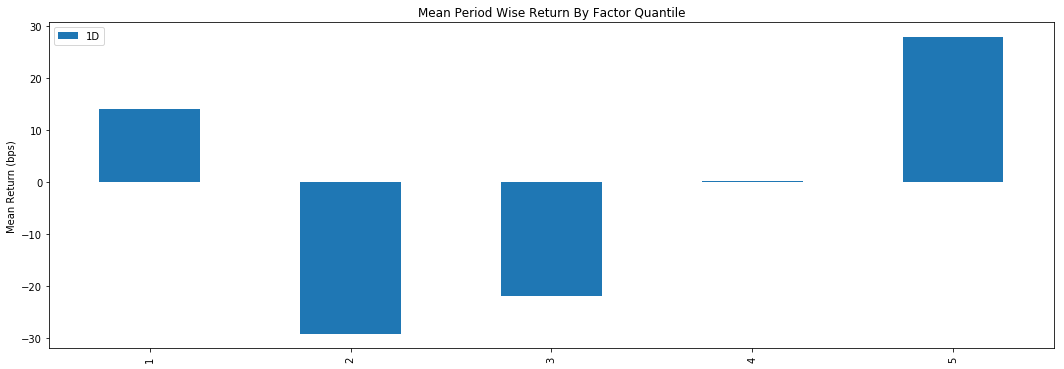

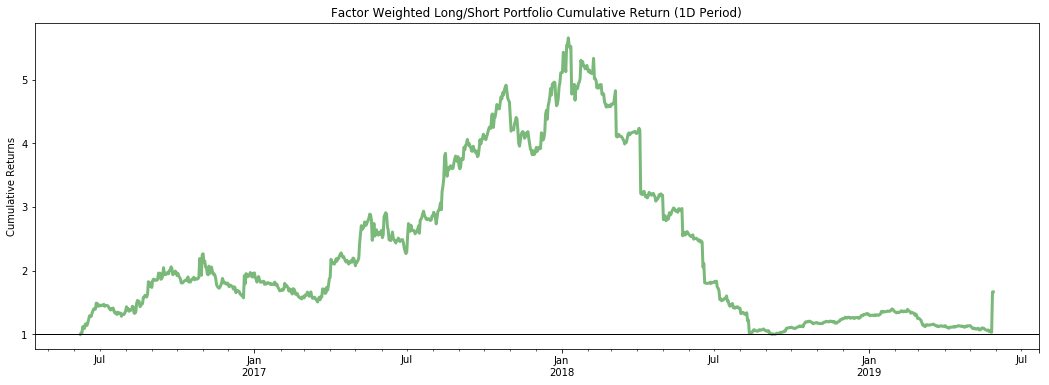

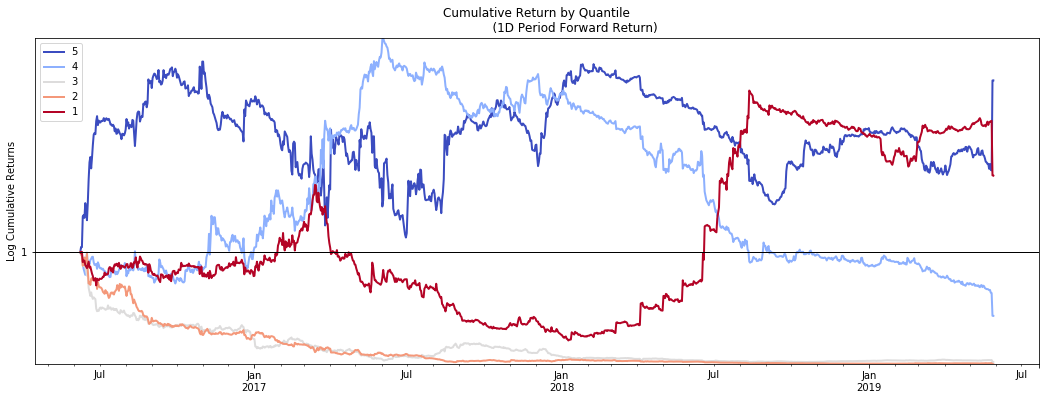

In [21]:
create_factor_charts1(factor_data)

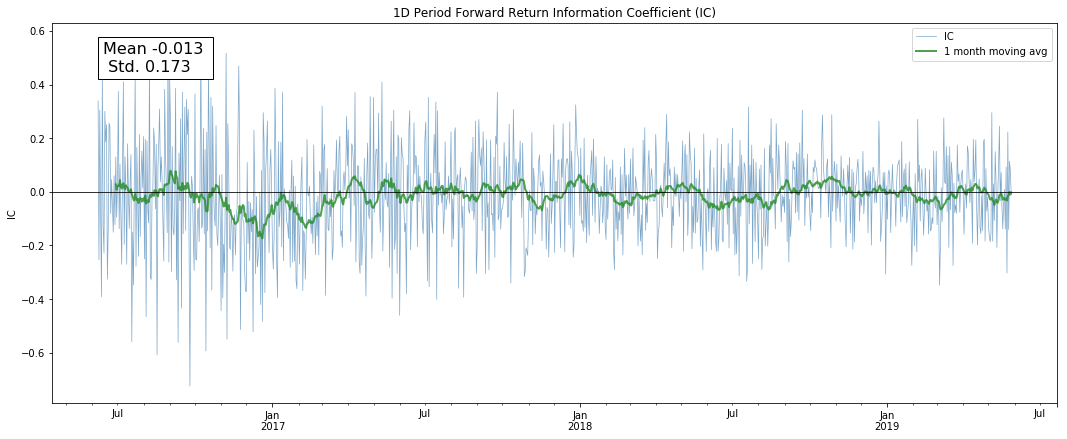

/home/leo/anaconda3/envs/research/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


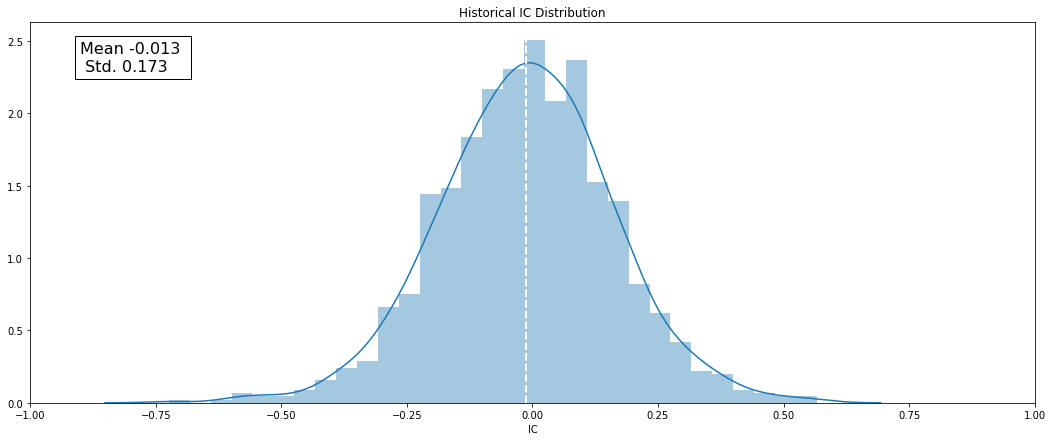

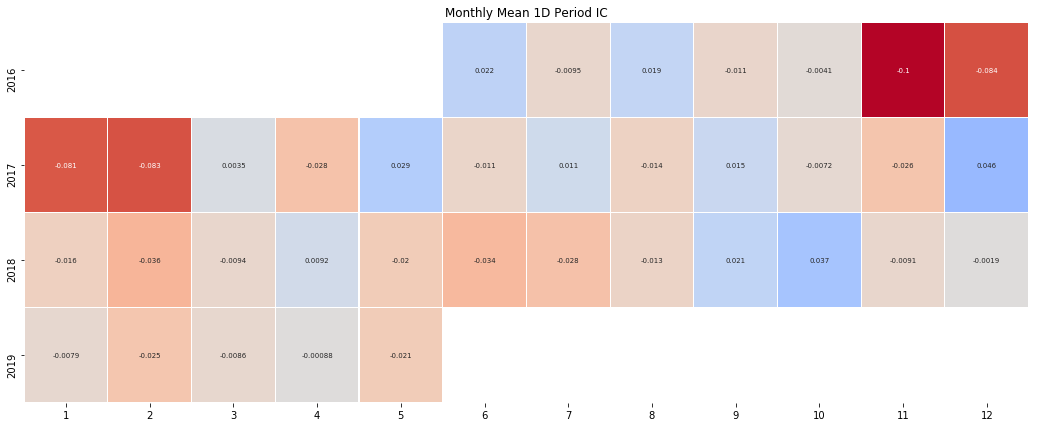

In [22]:
# Create the three information Coefficient charts on page three

import seaborn as sns
import matplotlib.cm as cm

ic = al.performance.factor_information_coefficient(factor_data)

al.plotting.plot_ic_ts(ic)
plt.savefig('./inputs/ic_chart_1.jpg')
plt.show()

m = ic.mean().values[0]

def plot_ic_dist(ic):
    fig, ax = plt.subplots(figsize = (18, 7))
    sns.distplot(ic.replace(np.nan, 0.), norm_hist = True, ax = ax)
    ax.set(title = 'Historical IC Distribution', xlabel = 'IC')
    ax.set_xlim([-1, 1])
    ax.text(.05, .95, "Mean %.3f \n Std. %.3f" % (ic.mean(), ic.std()),
               fontsize = 16,
               bbox = {'facecolor': 'white', 'alpha': 1, 'pad': 5},
               transform = ax.transAxes,
               verticalalignment = 'top')
    ax.axvline(m, color = 'w', linestyle = 'dashed', linewidth = 2)
                 
plot_ic_dist(ic)
plt.savefig('./inputs/ic_chart_2.jpg')
plt.show()

mean_monthly_ic = al.performance.mean_information_coefficient(factor_data, group_adjust=False, 
                                                              by_group=False, by_time="M")

def plot_ic_heatmap(mean_monthly_ic):
    new_index_year = []
    new_index_month = []
    for date in mean_monthly_ic.index:
        new_index_year.append(date.year)
        new_index_month.append(date.month)

    mean_monthly_ic.index = pd.MultiIndex.from_arrays(
        [new_index_year, new_index_month],
        names=["year", "month"])
    
    f, ax = plt.subplots(1, 1, figsize=(18, 7))
    #ax = ax.flatten()
    
    for a, (periods_num, ic) in zip([ax], mean_monthly_ic.iteritems()):

        sns.heatmap(
            ic.unstack(),
            annot=True,
            alpha=1.0,
            center=0.0,
            annot_kws={"size": 7},
            linewidths=0.01,
            linecolor='white',
            cmap=cm.coolwarm_r,
            cbar=False,
            ax=a)
        a.set(ylabel='', xlabel='')

        a.set_title("Monthly Mean {} Period IC".format(periods_num))
    
plot_ic_heatmap(mean_monthly_ic)
plt.savefig('./inputs/ic_chart_3.jpg')
plt.show()

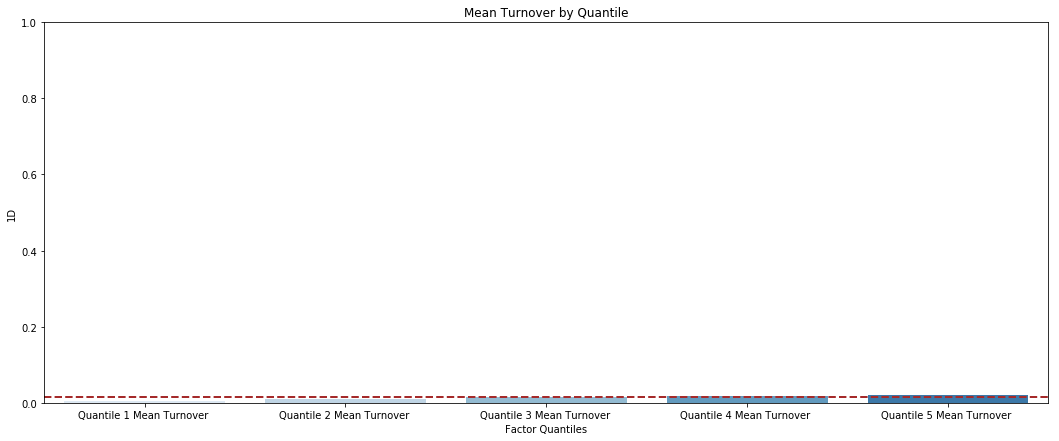

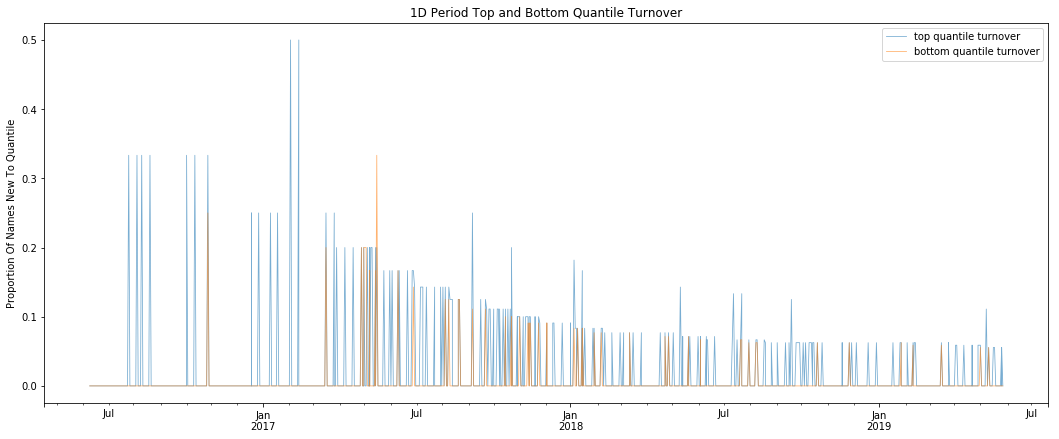

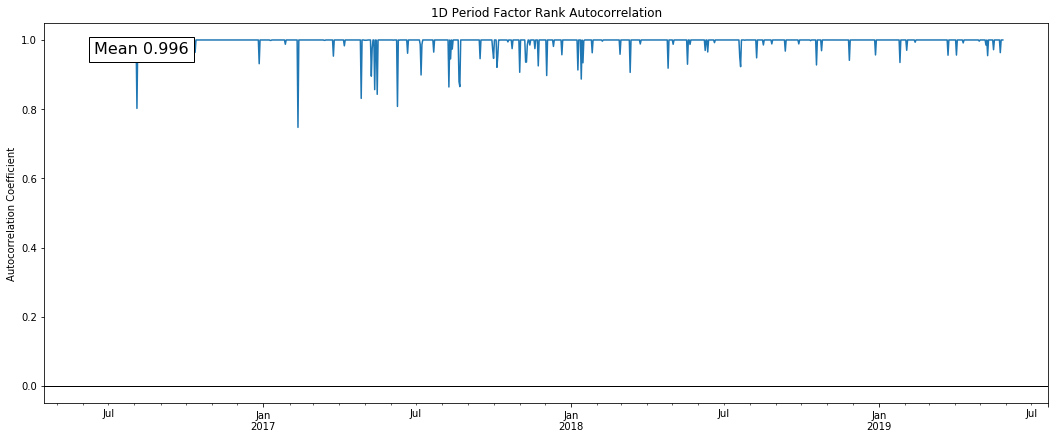

In [23]:
# Make the three turnover charts on page 4

turnover_periods = al.utils.get_forward_returns_columns(factor_data.columns)
quantile_factor = factor_data['factor_quantile']
quantile_turnover = \
        {p: pd.concat([al.performance.quantile_turnover(quantile_factor, q, p)
                       for q in range(1, int(quantile_factor.max()) + 1)],
                      axis=1)
            for p in turnover_periods}

autocorrelation = pd.concat(
        [al.performance.factor_rank_autocorrelation(factor_data, period) for period in
         turnover_periods], axis=1)

turnover_table = pd.DataFrame()
for period in sorted(quantile_turnover.keys()):
    for quantile, p_data in quantile_turnover[period].iteritems():
        turnover_table.loc["Quantile {} Mean Turnover ".format(quantile),"{}".format(period)] = p_data.mean()

turnover_table['Quantile'] = turnover_table.index
mean_turnover = turnover_table.mean().values[0]
fig, ax = plt.subplots(figsize = (18, 7))
sns.barplot(x = 'Quantile', y = '1D', data = turnover_table, ax = ax, palette = sns.color_palette('Blues'))
ax.set(ylim = (0, 1), title = 'Mean Turnover by Quantile', xlabel = 'Factor Quantiles')
ax.axhline(mean_turnover, color = 'brown', linestyle = 'dashed', linewidth = 2)
plt.savefig('./inputs/turn_chart_1.jpg')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(18, 7))

for period in turnover_periods:
    if quantile_turnover[period].isnull().all().all():
        continue
    al.plotting.plot_top_bottom_quantile_turnover(quantile_turnover[period], period=period, ax=ax)
    
plt.savefig('./inputs/turn_chart_2.jpg')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(18, 7))

for period in autocorrelation:
    if autocorrelation[period].isnull().all():
        continue
    al.plotting.plot_factor_rank_auto_correlation(autocorrelation[period], period=period, ax=ax)
    
plt.savefig('./inputs/turn_chart_3.jpg')
plt.show()